In [1]:
!pip install pandas numpy tqdm scikit-learn catboost shap >> None


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import shap
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from sklearn.metrics import roc_auc_score, f1_score

from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

# Load data

загружаем данные и убираем лишние пробелы до и после слова

In [3]:
events_df = pd.read_csv("Данные/Происшествия.csv")
events_df.replace('^\s+', '', regex=True, inplace=True) 
events_df.replace('\s+$', '', regex=True, inplace=True)

приводим названия МО в таблице Происшествия к единому формату 

In [4]:
events_df.replace("й", "й", inplace=True)
events_df.rename(columns={'Дата и время  пожара ': 'Местное время'}, inplace=True)
events_df = events_df[events_df["Район"] != "Пермский край"]

administrative_territories_to_replace = {
    "Верещагино ГО": "Верещагинский ГО",
    "Березники ГО": "ГО город Березники",
    "Гремячинск ГО": "Губахинский МО",
    "Губахинский ГО": "Губахинский МО",
    "Кизеловский ГО": "ГО город Кизел",
}

events_df.replace({"Район": administrative_territories_to_replace}, inplace=True)

In [5]:
weather_stats_df = pd.read_csv("Данные/Данные по метеостанциям.csv", low_memory=False)
weather_stats_df.replace('^\s+', '', regex=True, inplace=True) 
weather_stats_df.replace('\s+$', '', regex=True, inplace=True)
weather_stats_df.meteostation = weather_stats_df.meteostation.str.replace("й", "й")

In [6]:
respective_weather_df = pd.read_csv('Данные/Данные_по_метеостанциям_Соответствие_МО.csv')
respective_weather_df.replace('^\s+', '', regex=True, inplace=True) 
respective_weather_df.replace('\s+$', '', regex=True, inplace=True)
respective_weather_df.replace("й", "й", inplace=True)

In [7]:
predict_df = pd.read_csv('Данные/ОЯ и НЯ.csv')
predict_df.rename(columns={'Дата, время начала': 'Местное время'}, inplace=True)
predict_df.replace('^\s+', '', regex=True, inplace=True) 
predict_df.replace('\s+$', '', regex=True, inplace=True)

# Data preprocessing

переводим МО в название метеостанции которая отвечает за этот округ

In [8]:
MO_to_weather_station = dict(respective_weather_df.values)
MO_to_weather_station = {x: y.split()[1] for x, y in MO_to_weather_station.items()}

In [9]:
events_df['meteostation'] = events_df['Район'].map(MO_to_weather_station)

приводим названия метеостанций к одному формату

In [10]:
meteostations_to_replace = {
    "Большая": "Большая Соснова",
    "Кочёво": "Кочево",
}

events_df.replace({"meteostation": meteostations_to_replace}, inplace=True)

переводим время из строки в таймстампы

In [11]:
weather_stats_df["Местное время"] = pd.to_datetime(weather_stats_df["Местное время"], format="%d.%m.%Y %H:%M")
events_df["Местное время"] = pd.to_datetime(events_df["Местное время"], format="%Y-%m-%d %H:%M:%S")
predict_df["Местное время"] = pd.to_datetime(predict_df["Местное время"], format="%Y-%m-%d %H:%M:%S")

In [12]:
events_df["timestamp"] = pd.to_numeric(events_df["Местное время"])
weather_stats_df["timestamp"] = pd.to_numeric(weather_stats_df["Местное время"])

изменяем дату в events_df на максимально приближенную к дате из weather_df

In [13]:
events_timestamps = list(events_df["timestamp"])
weather_stats_timestamps = list(sorted(set(weather_stats_df["timestamp"])))
new_events_timestamps = events_timestamps
weather_stats_iterator = 0
events_iterator = 0
while events_iterator != len(events_timestamps):
    if weather_stats_iterator == len(weather_stats_timestamps) - 1:
        new_events_timestamps[events_iterator] = weather_stats_timestamps[weather_stats_iterator]
    elif events_timestamps[events_iterator] > weather_stats_timestamps[weather_stats_iterator + 1]:
        weather_stats_iterator += 1
    else:
        new_events_timestamps[events_iterator] = weather_stats_timestamps[weather_stats_iterator]
        events_iterator += 1
events_df["timestamp"] = new_events_timestamps
events_df

,Район,Тип,Местное время,meteostation,timestamp
0,ГО город Березники,Пожар с гибелью 2-х и более человек,2012-12-18 20:39:00,Березники,1357005600000000000
1,Пермский МО,Особо опасные болезни сельскохозяйственных жив...,2013-01-01 00:00:00,Пермь,1357005600000000000
2,Юрлинский МО,Особо опасные болезни сельскохозяйственных жив...,2013-01-01 00:00:00,Кочево,1357005600000000000
3,Карагайский МО,Особо опасные болезни сельскохозяйственных жив...,2013-01-01 00:00:00,Верещагино,1357005600000000000
4,Добрянский ГО,Пожар с гибелью 2-х и более человек,2013-01-01 07:50:00,Добрянка,1357016400000000000
...,...,...,...,...,...
3649,Пермский ГО,Аварийные ситуации на ЖД транспорте,2022-12-08 11:50:00,Пермь,1670497200000000000
3650,Пермский ГО,Пожары на объектах торговли,2022-12-16 18:01:00,Пермь,1671210000000000000
3651,Пермский МО,"Крупные ДТП (повреждение 10 и более а/м, ДТП с...",2022-12-25 21:00:00,Пермь,1671998400000000000
3652,Пермский ГО,"Аварии на магистральных газо-, нефте-, продукт...",2022-12-28 13:03:00,Пермь,1672225200000000000


In [14]:
events_df["Местное время"] = pd.to_datetime(events_df["timestamp"])
events_df.drop("timestamp", axis=1, inplace=True)

соединяем данные по погоде и события, которые произошли в определенное время 

In [15]:
merged_df = weather_stats_df.merge(events_df, on=['meteostation', 'Местное время'], how='left')

добавляем фичи дня

In [16]:
merged_df['Тип'] = merged_df['Тип'].fillna('Нет события')
merged_df['Район'] = merged_df['Район'].fillna('')

уменьшаем количество уникальных названий классов до базового набора из пяти категорий

In [17]:
type_convertation = {"Абразия": "Опасные природные явления",
 "Аварии (катастрофы) на автодорогах (на транспорте, перевозящем опасные грузы)": "ДТП",
 "Аварии на внутрипромысловых нефтепроводах": "Аварии с выбросом опасных/токсичных веществ",
 "Аварии на коммунальных системах жизнеобеспечения Водозаборы, очистные сооружени": "ЖКХ",
 "Аварии на коммунальных системах жизнеобеспечения ГВС": "ЖКХ",
 "Аварии на коммунальных системах жизнеобеспечения Газоснабжение": "ЖКХ",
 "Аварии на коммунальных системах жизнеобеспечения Канализации": "ЖКХ",
 "Аварии на коммунальных системах жизнеобеспечения Котельные": "ЖКХ",
 "Аварии на коммунальных системах жизнеобеспечения Теплоснабжение": "ЖКХ",
 "Аварии на коммунальных системах жизнеобеспечения ХВС": "ЖКХ",
 "Аварии на магистральных газо-, нефте-, продукто-проводах": "Аварии с выбросом опасных/токсичных веществ",
 "Аварии на магистральных газо-, нефте-, продукто-проводах Канализации": "Аварии с выбросом опасных/токсичных веществ",
 "Аварии на очистных сооружениях": "ЖКХ",
 "Аварии на электроэнергетических системах": "ЖКХ",
 "Аварии на электроэнергетических системах ГВС": "ЖКХ",
 "Аварии на электроэнергетических системах ХВС": "ЖКХ",
 "Аварии с выбросом или сбросом (угрозой выброса) АХОВ": "Аварии с выбросом опасных/токсичных веществ",
 "Аварийные ситуации на ЖД транспорте": "ДТП",
 "Авиационные катастрофы, аварии в аэропортах, в населённых пунктах": "ДТП",
 "Взрыв газа": "Взрывы/пожары/разрушения",
 "Внезапное обрушение зданий, сооружений, пород": "Взрывы/пожары/разрушения",
 "Гидродинамические аварии": "Аварии с выбросом опасных/токсичных веществ",
 "Загрязнения окружающей среды": "Аварии с выбросом опасных/токсичных веществ",
 "Зажор, затор, дождевой паводок": "Опасные природные явления",
 "Заморозки": "Опасные природные явления",
 "Засуха": "Опасные природные явления",
 "Инфекционные заболевания людей невыясненной этиологии": "Прочие опасности",
 "Карстовая просадка (провал) земной поверхности, просадка лессовых пород": "Взрывы/пожары/разрушения",
 "Кораблекрушения, аварии, повреждения грузовых, пассажирских судов, повреждения судами береговых, гидротехнических и др. объектов": "ДТП",
 "Крупные ДТП (повреждение 10 и более а/м, ДТП с тяжкими последствиями)": "ДТП",
 "Крушение поезда": "ДТП",
 "Крушения и аварии грузовых и пассажирских поездов": "ДТП",
 "Лесные пожары": "Взрывы/пожары/разрушения",
 "Массовая гибель рыб": "Прочие опасности",
 "Нет события": "Нет события",
 "Обнаружение неразорвавшихся боеприпасов, взрывчатых веществ": "Прочие опасности",
 "Опасные кишечные инфекции людей": "Прочие опасности",
 "Оползни, обвалы, осыпи": "Опасные природные явления",
 "Особо опасные болезни сельскохозяйственных животных": "Прочие опасности",
 "Отравления людей": "Прочие опасности",
 "Отрыв прибрежных льдин": "Опасные природные явления",
 "Перерыв в движении на главных магистралей": "Прочие опасности",
 "Переувлажнение почвы": "Опасные природные явления",
 "Пожар с гибелью 2-х и более человек": "Взрывы/пожары/разрушения",
 "Пожары на магистральных газо-, нефте-, продуктопроводах": "Взрывы/пожары/разрушения",
 "Пожары на объектах сельскохозяйственного назначения": "Взрывы/пожары/разрушения",
 "Пожары на объектах торговли": "Взрывы/пожары/разрушения",
 "Пожары на социально-значимых объектах (образования, культуры, здравоохранения и др.)": "Взрывы/пожары/разрушения",
 "Пожары на транспортных средствах (ж/д, водный, автомобильный, воздушный)": "Взрывы/пожары/разрушения",
 "Пожары повышенного номера": "Взрывы/пожары/разрушения",
 "Половодье": "Опасные природные явления",
 "Происшествия на водных объектах": "Прочие опасности",
 "Пропажа людей": "Прочие опасности",
 "Сильный ветер": "Опасные природные явления",
 "Сильный дождь": "Опасные природные явления",
 "Сильный снег": "Опасные природные явления",
 "Сильный туман": "Опасные природные явления",
 "Транспортные катастрофы и аварии на мостах, переправах, на ж/д переездах": "ДТП",
 "Угроза террористического акта": "Прочие опасности",
 "Ухудшение качества питьевой воды": "Прочие опасности"}

In [18]:
merged_df['Тип'] = merged_df['Тип'].map(lambda x: type_convertation[x] if x in type_convertation else 'Нет события')

список новых названий классов

In [19]:
merged_df['Тип'].value_counts()

Тип
Нет события                                    566496
ЖКХ                                              1791
Взрывы/пожары/разрушения                          538
Прочие опасности                                  285
Аварии с выбросом опасных/токсичных веществ       221
Опасные природные явления                         179
ДТП                                               139
Name: count, dtype: int64

In [20]:
target_values = list(set(merged_df['Тип']))

In [21]:
for target_type in target_values:
    merged_df[target_type] = merged_df['Тип'] == target_type

In [22]:
merged_selected_df = merged_df.copy()

# Data shifts

для каждого из сэмплов формируем окно значений погоды за последние 10 сообщений

In [23]:
merged_selected_df['RRR'] = merged_selected_df['RRR'].map(lambda x: x if x not in ['Осадков нет', 'Следы осадков'] else 0)
merged_selected_df['sss'] = merged_selected_df['sss'].map(lambda x: x if x not in ['Снежный покров не постоянный.'] else 0)

In [24]:
selected_columns = ['T', 'Td', 'P', 'Po', 'Pa', 'U', 'DD', 'Ff', 'ff10', 
                       'ff3', 'N', 'WW', 'W1', 'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm',
                   'Ch', 'RRR', 'tR', 'E', 'Tg', "E'"]
cat_features = ['DD', 'N', 'W1', 'W2', 'WW', 'Cl', 'Nh', 'H', 'Cm', 'Ch', 'E', "E'"]

In [25]:
merged_selected_df = merged_selected_df[['Местное время', 'Тип', 'Район', 'meteostation', *selected_columns, *target_values]]

In [26]:
merged_selected_df = merged_selected_df.sort_values(by=['Местное время'])

In [27]:
dfs = []
for meteo in set(merged_selected_df['meteostation'].tolist()):
    class_df = merged_selected_df[merged_selected_df['meteostation'] == meteo]
    for column in selected_columns:
        for i in range(10):
            class_df[f"{column}_lag{i}"] = class_df[column].shift(i)
    dfs.append(class_df)

In [28]:
merged_selected_df = pd.concat(dfs, ignore_index=False)

# Metric decision

Так как на одно время может произойти два инцидента, то это уже не задача мултиклассификации, а задача мультиклассификации. Также у нас присутствует дисбаланс классов, соотвественно в качестве метрики валидации мы будем использовать F1_score(mode='macro'). Это среднее из f1_score по каждому из возможных классов

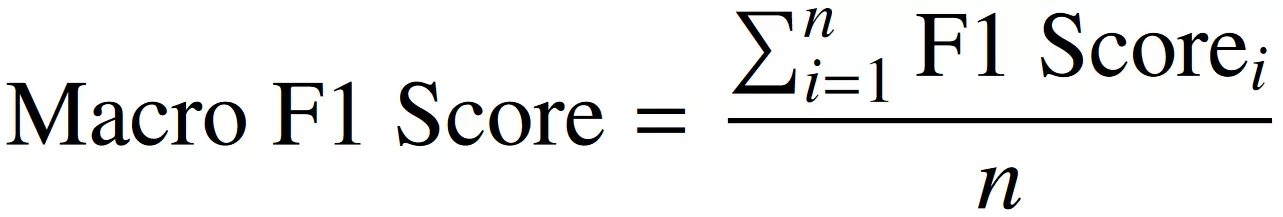

тренировать мы будем 5 бинарных моделей, чтобы работать с каждым классом

# Model training (CatBoost)

In [29]:
def downsample(df, value, fraction=1):
        """
        function to downsample majority class.
        """
        # Separate the majority and minority classes
        if value == 'Нет события':
            majority_class = df[df[value] != False]
            minority_class = df[df[value] == False] 
        else:
            majority_class = df[df[value] == False]
            minority_class = df[df[value] != False]  
        
        # Calculate the number of samples needed from the majority class
        num_samples = len(minority_class)
        
        downsampled_majority = majority_class.sample(frac=(len(minority_class) / len(majority_class)), replace=True) 
        
        downsampled_df = pd.concat([downsampled_majority, minority_class], axis=0)
        
        return downsampled_df

In [30]:
def train_model(X, y):
    """
    функция для тренировки модели
    """
    clfs = []
    scores = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    
    for train_index, test_index in kf.split(X, y):
    
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = CatBoostClassifier(
            depth=7,
            iterations=500,
            learning_rate=0.06,
            loss_function="MultiClass", 
            eval_metric="TotalF1:average=Macro", 
            custom_metric="TotalF1:average=Macro",
            boosting_type="Ordered",
            
            # Главная фишка катбуста - работа с категориальными признаками
            cat_features=cat_features,
            # ignored_features = ignored_features,
            
            # Регуляризация и ускорение
            colsample_bylevel=0.098,
            subsample=0.95,
            l2_leaf_reg=9,
            min_data_in_leaf=243,
            max_bin=187,
            random_strength=1,
            
            # Параметры ускорения
            task_type="CPU",    
            thread_count=-1,
            bootstrap_type="Bernoulli", 
            
            # Важное!
            random_seed=7575,
            # auto_class_weights="SqrtBalanced",
            early_stopping_rounds=50)
    
        clfs.append(clf)
    
        clf.fit(
            Pool(X_train, y_train, cat_features=cat_features),
            eval_set=Pool(X_test, y_test, cat_features=cat_features),
            verbose=False,
            use_best_model=True,
            plot=False)
    
        y_pred = clf.predict(X_test)
        score = f1_score(list(map(str, y_test)), y_pred, average="macro")  # np.mean(np.array(y_pred == y_test))
        scores.append(score)
        print(f"fold: f1 score: {score}")
    
    assert len(clfs) == n_splits
    print(
        "mean f1 score ====>>> " + str(np.mean(scores, dtype="float32")) + " <<<====", np.std(scores).round(4), '\n'
    )
    return clfs, np.mean(scores, dtype="float32")

начинаем тренировку моделей! CatBoostClassifier

In [31]:
scores = []
total_clfs = []
for column in target_values:
    print(column)
    train_df = merged_selected_df.copy()

    train_df = downsample(train_df, column, fraction=0.01)
    train_df['Тип'] = train_df['Тип'] == column

    print(train_df['Тип'].value_counts())
    
    n_splits = 5
    
    target_column = 'Тип'
    cat_features = [column for column in train_df.columns if any(map(lambda x: column.startswith(x), cat_features))] + ['meteostation']
    for cat_feature in cat_features:
        try:
            train_df[cat_feature] = train_df[cat_feature].fillna('')
        except Exception as e:
            print(e)
        train_df[cat_feature] = train_df[cat_feature].astype('category')
    text_features = ['WW']
    
    X = train_df.drop(columns=[target_column, 'Район', 'Местное время', *target_values]) # 'meteostation'
    y = train_df[target_column]

    clfs, f1_value = train_model(X, y)
    total_clfs.append(clfs)
    scores.append(f1_value)
print(scores)
print(target_values)

ДТП
Тип
False    139
True     139
Name: count, dtype: int64
fold: f1 score: 0.7846153846153845
fold: f1 score: 0.8571428571428571
fold: f1 score: 0.8019929283188685
fold: f1 score: 0.7999999999999999
fold: f1 score: 0.7269116186693148
mean f1 score ====>>> 0.79413253 <<<==== 0.0417 

Нет события
Тип
True     3153
False    3153
Name: count, dtype: int64
Cannot setitem on a Categorical with a new category (), set the categories first
fold: f1 score: 0.7301951953851409
fold: f1 score: 0.7552959157937853
fold: f1 score: 0.7734052111410603
fold: f1 score: 0.7124342144964729
fold: f1 score: 0.7519969742813919
mean f1 score ====>>> 0.7446655 <<<==== 0.0212 

ЖКХ
Тип
False    1791
True     1791
Name: count, dtype: int64
Cannot setitem on a Categorical with a new category (), set the categories first
fold: f1 score: 0.7934682755936162
fold: f1 score: 0.7616952890390389
fold: f1 score: 0.7737359550561798
fold: f1 score: 0.7723352664977342
fold: f1 score: 0.7835191307994656
mean f1 score ====>>> 

In [32]:
np.mean(scores)

0.78283787

**итоговый f1-score CatBoost модели равен среднему из каждого скора ==== 0.7794555** 

# Explain reasons to select such predicts

смотрим на фичи, которые оказались важными для модели класса ЖКХ

In [40]:
column = 'ЖКХ'

train_df = merged_selected_df.copy()

train_df = downsample(train_df, column, fraction=0.01)
train_df['Тип'] = train_df['Тип'] == column

n_splits = 5

target_column = 'Тип'
cat_features = [column for column in train_df.columns if any(map(lambda x: column.startswith(x), cat_features))] + ['meteostation']
for cat_feature in cat_features:
    try:
        train_df[cat_feature] = train_df[cat_feature].fillna('')
    except Exception as e:
        print(e)
    train_df[cat_feature] = train_df[cat_feature].astype('category')
text_features = ['WW']

X = train_df.drop(columns=[target_column, 'Район', 'Местное время', *target_values]) # 'meteostation'
y = train_df[target_column]

Cannot setitem on a Categorical with a new category (), set the categories first


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

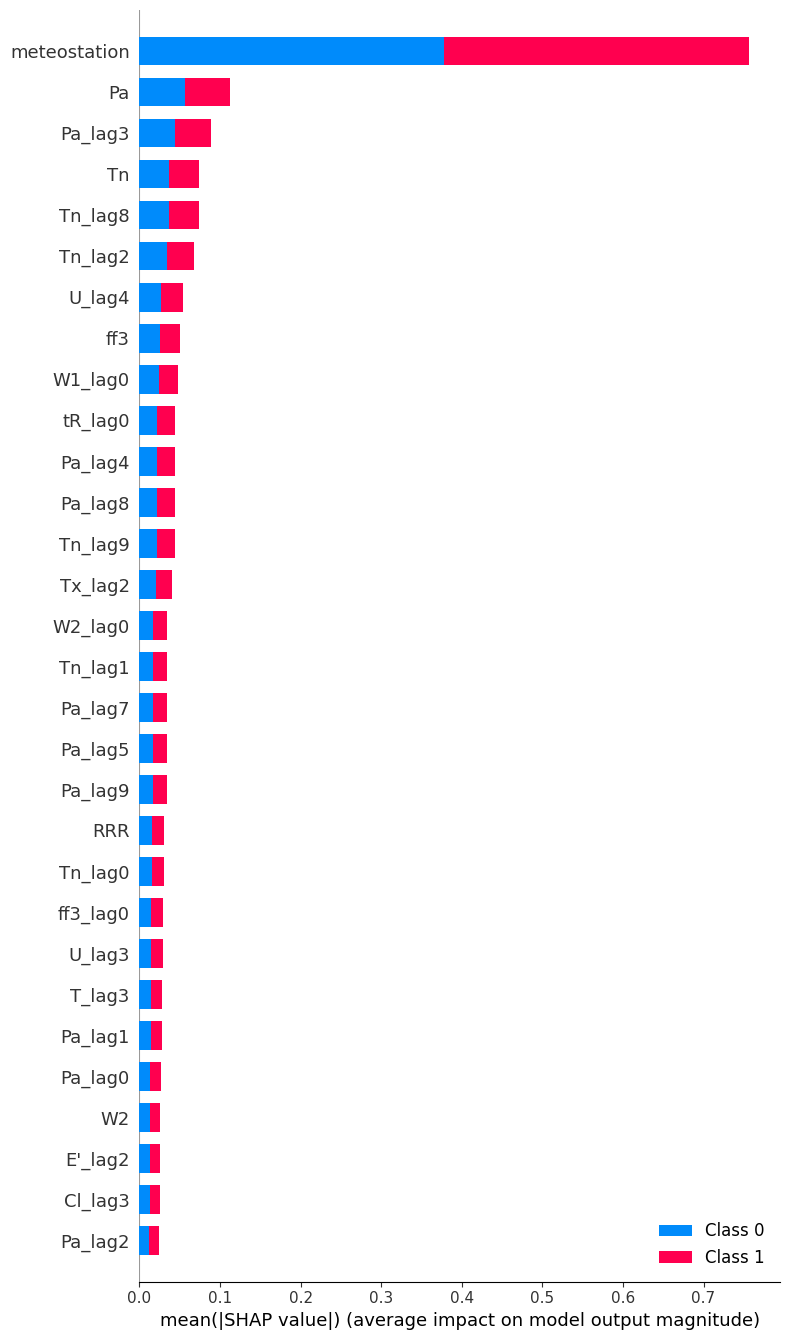

In [42]:
explainer = shap.TreeExplainer(total_clfs[target_values.index(column)][0])

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display=30)

сохраняем модели

In [43]:
for j, column in enumerate(target_values):
    for i, clf in enumerate(total_clfs[j]):
        clf.save_model(f"models/{column.replace('/', '_')}_classificator{i}.cbm",
               format="cbm")

# Inference

код для инференса только для одной метеостанции

In [44]:
inf_columns = X.columns.tolist()

In [45]:
target_values

['ДТП',
 'Нет события',
 'ЖКХ',
 'Опасные природные явления',
 'Взрывы/пожары/разрушения',
 'Аварии с выбросом опасных/токсичных веществ',
 'Прочие опасности']

In [ ]:
weather_stats_df = pd.read_csv("Данные/Данные по метеостанциям.csv", low_memory=False)
weather_stats_df.replace('^\s+', '', regex=True, inplace=True) 
weather_stats_df.replace('\s+$', '', regex=True, inplace=True)
weather_stats_df["Местное время"] = pd.to_datetime(weather_stats_df["Местное время"], format="%d.%m.%Y %H:%M")

for column in target_values:

    for i, clf in enumerate(total_clfs[target_values.index(column)]):
        clf.save_model(f"models/classificator{i}.cbm",
               format="cbm")
    
    meteostation = 'Чердынь'
    
    meteo_df = weather_stats_df[weather_stats_df['meteostation'] == meteostation].copy()
    
    meteo_df = meteo_df.sort_values(by=['Местное время'])
    meteo_df['RRR'] = meteo_df['RRR'].map(lambda x: x if x not in ['Осадков нет', 'Следы осадков'] else 0)
    
    for column in selected_columns:
        for i in range(10):
            meteo_df[f"{column}_lag{i}"] = meteo_df[column].shift(i)
    
    # meteo_df = meteo_df.iloc[-8 * 10:]
    
    for cat_feature in cat_features:
        try:
            meteo_df[cat_feature] = meteo_df[cat_feature].fillna('')
        except Exception as e:
            pass
        meteo_df[cat_feature] = meteo_df[cat_feature].astype('category')
    
    X = meteo_df.drop(columns=['Местное время'])
    X = X[inf_columns]
    
    clfs = [CatBoostClassifier().load_model(f"models/classificator{i}.cbm", format="cbm") for i in range(5)]
    
    predict_matrix = np.array([clf.predict_proba(X) for clf in clfs]).mean(axis=0)
    
    print(list(predict_matrix.argmax(axis=1)))

# Train TabNet model